<a href="https://colab.research.google.com/github/DiegoOCruz/Artificial-Projeto-de-bloco/blob/main/TP4_PB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the '-spotify-tracks-dataset' dataset.
Número de linhas: 30000

Executando o Método do Cotovelo...


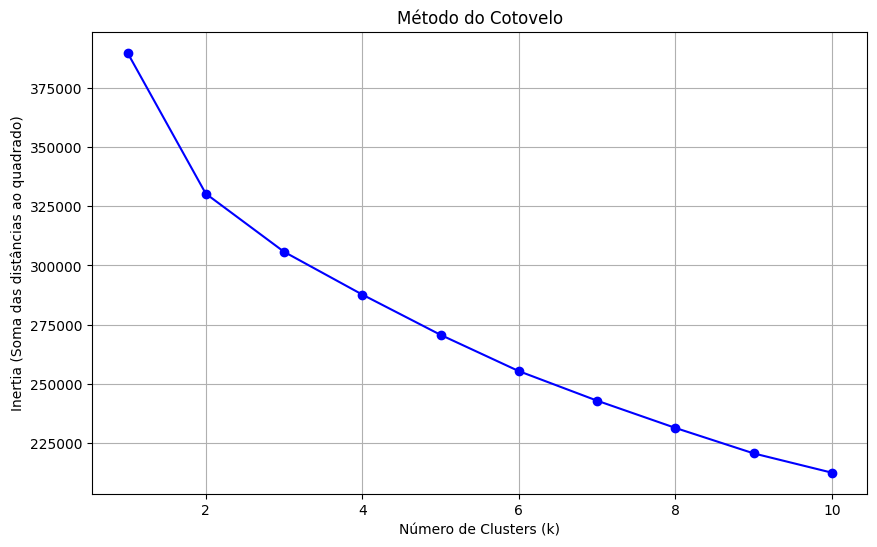

Melhor k baseado no silhouette score: 2

Análise das características médias de cada cluster:
           duration_ms  danceability    energy       key   loudness      mode  \
cluster                                                                         
0        217995.276171      0.469360  0.310527  4.968809 -13.963954  0.711111   
1        231094.970084      0.598151  0.750467  5.434576  -6.344992  0.613582   

         speechiness  acousticness  instrumentalness  liveness   valence  \
cluster                                                                    
0           0.059216      0.737220          0.291932  0.181030  0.320826   
1           0.092691      0.175043          0.106634  0.225126  0.525164   

              tempo  time_signature  
cluster                              
0        110.149552        3.720750  
1        126.307225        3.969108  

Tamanho do conjunto de treino: 24000
Tamanho do conjunto de teste: 6000

Nº de componentes PCA (original): 11
Nº de componen

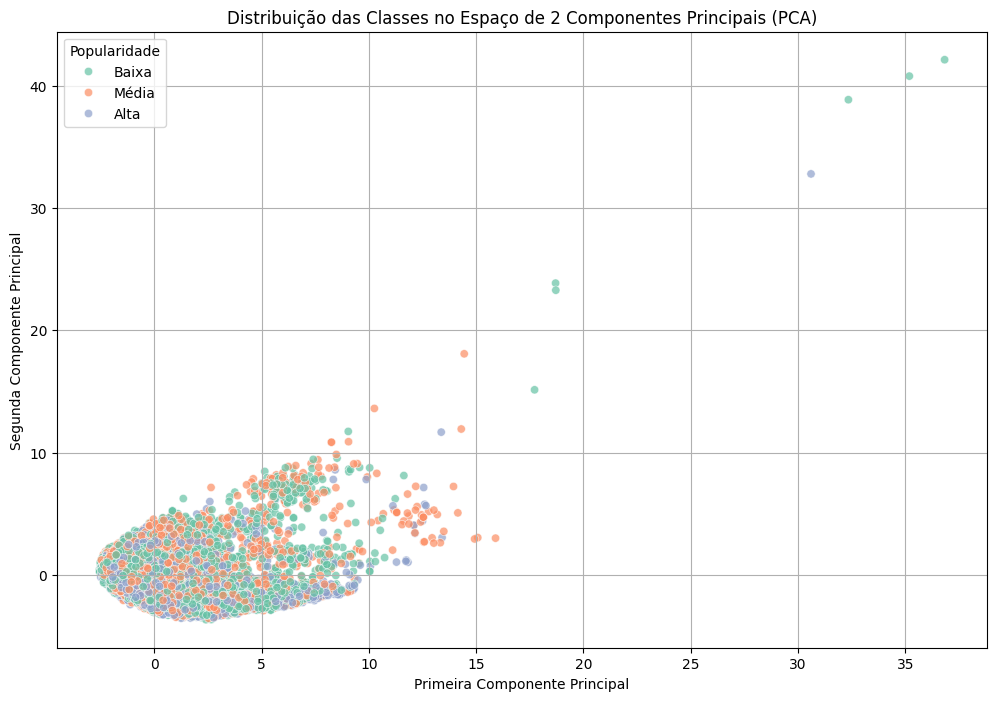

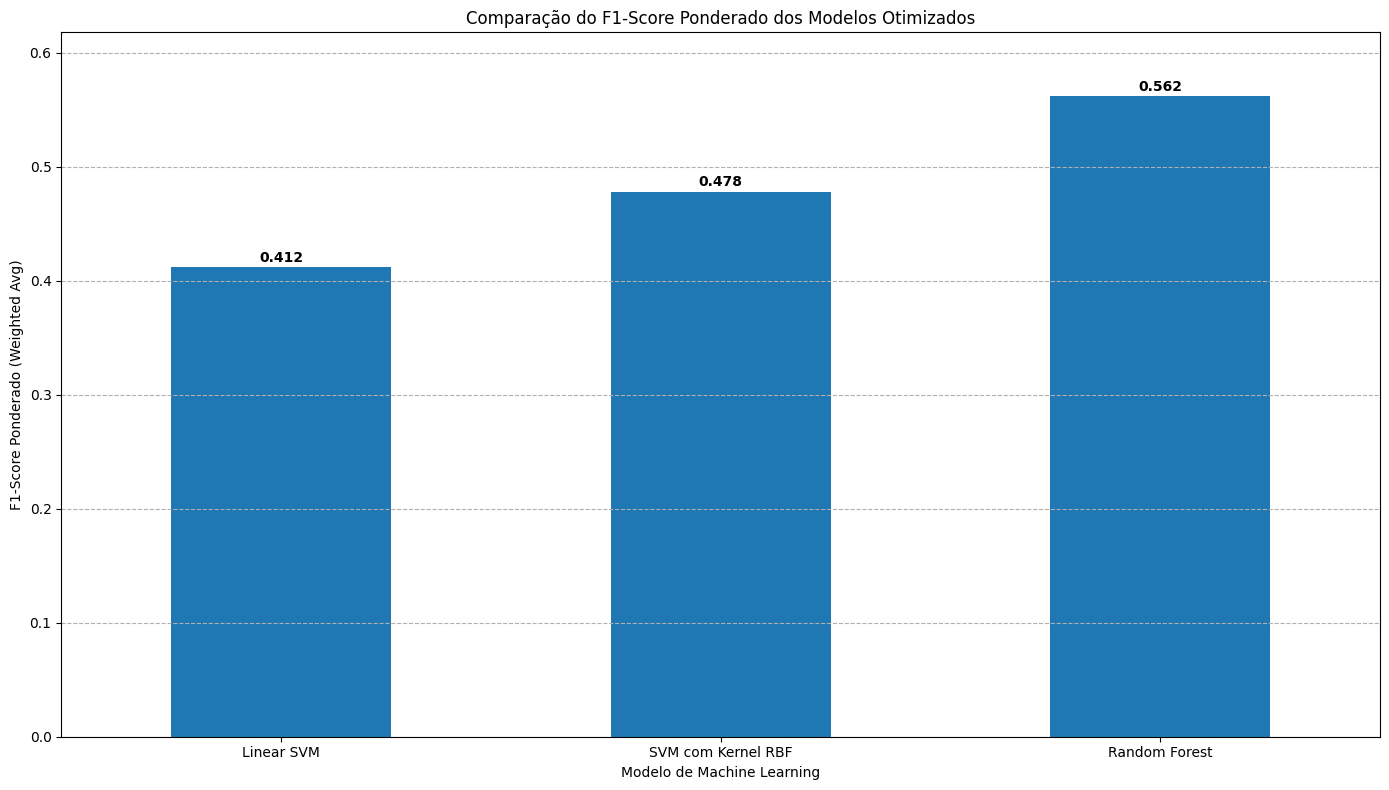

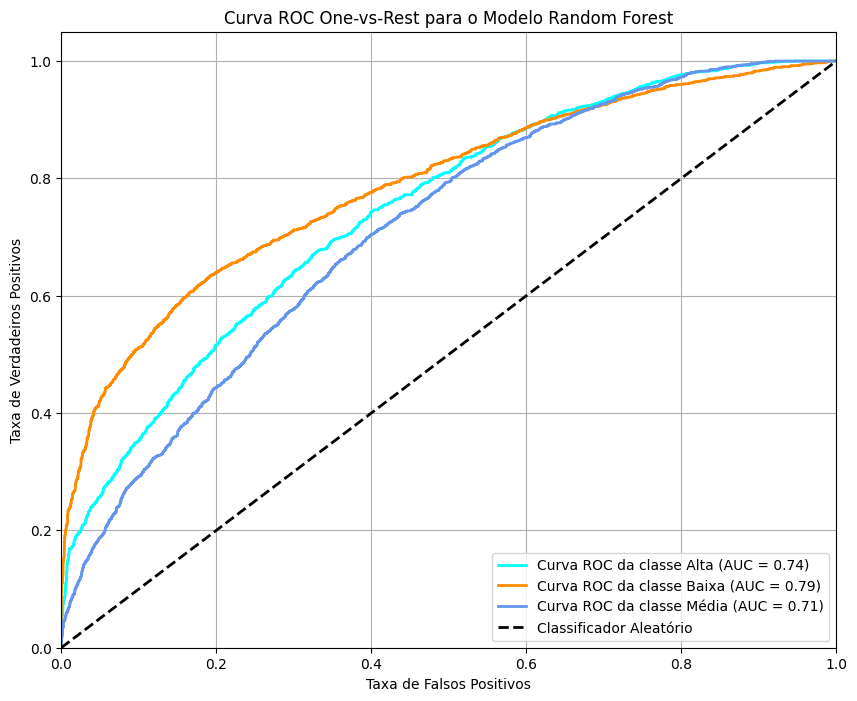

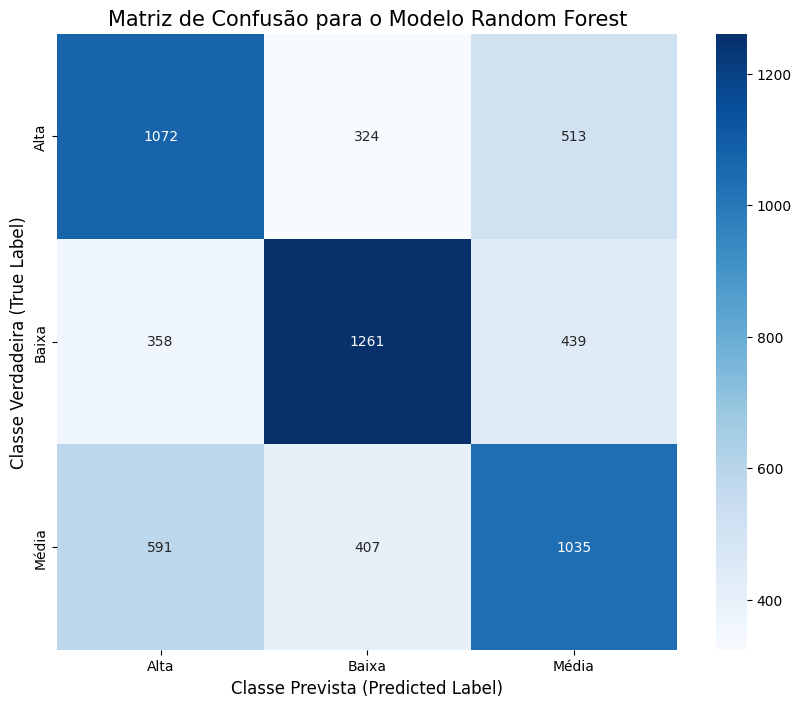

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, silhouette_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# =====================
# 1. Carregar e preparar o dataset
# =====================
file_path = "dataset.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "maharshipandya/-spotify-tracks-dataset",
    file_path
)

df = df.sample(n=30_000, random_state=42)# 30k é o máximo viável, demorou ~30min
df.reset_index(drop=True, inplace=True)
print(f"Número de linhas: {len(df)}")

# =====================
# 2. Selecionar features e criar o target
# =====================

# features = ['duration_ms', 'danceability', 'energy', 'loudness',
#            'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']
# X = df[features]

#colunas numéricas - teste 6
#X = df.select_dtypes(include=[np.number])
# Selecionar colunas numéricas, removendo o alvo e identificadores
features_para_remover = ['popularity', 'Unnamed: 0']
colunas_numericas = df.select_dtypes(include=np.number).columns
features_finais = [col for col in colunas_numericas if col not in features_para_remover]

X = df[features_finais]

# Criar a variável alvo (target) baseada na popularidade

#df['popularity_class'] = pd.cut(df['popularity'], bins=[-1, 33, 66, 101], labels=['Baixa', 'Média', 'Alta'])
df['popularity_class'] = pd.qcut(df['popularity'], q=3, labels=['Baixa', 'Média', 'Alta'])
y = df['popularity_class']

# Normalizar as features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =====================
# 3. Clusterização K-Médias e Engenharia de Features
# =====================

# --- Método do Cotovelo para escolher o número ideal de clusters ---
print("\nExecutando o Método do Cotovelo...")
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(X_scaled)
    inertia.append(kmeans_test.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inertia (Soma das distâncias ao quadrado)')
plt.title('Método do Cotovelo')
plt.grid(True)
plt.show()

#
# best_k = 3 # Escolhido com base no gráfico
# print(f"\nNúmero de clusters escolhido: {best_k}")
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
best_k = range(2, 11)[np.argmax(silhouette_scores)]
print(f"Melhor k baseado no silhouette score: {best_k}")

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# distância de cada ponto aos centroides dos clusters
distances = kmeans.transform(X_scaled)

# Criar o dataset estendido (features originais + distâncias)
X_extended = np.hstack([X_scaled, distances])

# --- Análise dos Clusters Gerados ---
print("\nAnálise das características médias de cada cluster:")
df['cluster'] = kmeans.labels_
features = X.columns
cluster_analysis = df.groupby('cluster')[features].mean()
print(cluster_analysis)

# =====================
# 4. Divisão treino/teste
# =====================
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividindo o dataset original (apenas scaled)
X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Dividindo o dataset estendido (com features de cluster)
X_train_ext, X_test_ext, _, _ = train_test_split(
    X_extended, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTamanho do conjunto de treino: {X_train_orig.shape[0]}")
print(f"Tamanho do conjunto de teste: {X_test_orig.shape[0]}")

# =====================
# 5. PCA - Redução de Dimensionalidade
# =====================
# O PCA é treinado (fit) APENAS nos dados de treino e depois aplicado (transform) em ambos
pca = PCA(n_components=0.95, random_state=42) # 95% da variância

# PCA para o dataset original
X_train_pca_orig = pca.fit_transform(X_train_orig)
X_test_pca_orig = pca.transform(X_test_orig)

# PCA para o dataset estendido
X_train_pca_ext = pca.fit_transform(X_train_ext)
X_test_pca_ext = pca.transform(X_test_ext)

print(f"\nNº de componentes PCA (original): {X_train_pca_orig.shape[1]}")
print(f"Nº de componentes PCA (estendido): {X_train_pca_ext.shape[1]}")

# =====================
# 6. Treinamento e Avaliação dos Modelos
# =====================
models = {
    "Linear SVM": LinearSVC(class_weight='balanced', max_iter=5000, random_state=42),
    "SVM com Kernel RBF": SVC(kernel='rbf', class_weight='balanced', random_state=42, probability=True),
    "SVM com Kernel Poly": SVC(kernel='poly', class_weight='balanced', random_state=42, probability=True), # muito lento
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
}

results = {}

# Dicionário para armazenar os resultados para o gráfico final
results = {}

# --- Modelo de Referência: Linear SVM  ---
print("\n===== TREINANDO: Linear SVM =====")
model_linear_svm = LinearSVC(class_weight='balanced', max_iter=5000, random_state=42)
# Usando features estendidas
model_linear_svm.fit(X_train_pca_ext, y_train)
y_pred_ext = model_linear_svm.predict(X_test_pca_ext)
report_ext = classification_report(y_test, y_pred_ext, target_names=le.classes_, zero_division=0, output_dict=True)
print("\n--- Com Features de Clusterização ---")
print(classification_report(y_test, y_pred_ext, target_names=le.classes_, zero_division=0))
results['Linear SVM'] = {'Com Cluster Features': report_ext['weighted avg']['f1-score']}


# --- Otimização do SVM com Kernel RBF usando GridSearchCV ---
print("\n===== OTIMIZANDO: SVM com Kernel RBF (GridSearch) =====")

param_grid_svm = {
    'C': [1, 10],
    'gamma': ['scale', 'auto']
}

# 2. Configurar o GridSearchCV
# usando F1-score ponderado como métrica de avaliação
grid_search_svm = GridSearchCV(
    estimator=SVC(kernel='rbf', class_weight='balanced', random_state=42, probability=True),
    param_grid=param_grid_svm,
    scoring='f1_weighted',
    cv=3,  # 3-fold cross-validation.
    n_jobs=-1, # Usar todos os processadores disponíveis
    verbose=2  # Mostra o progresso
)

# 3. Executar a busca nos dados com features de clusterização
print("\n--- Buscando melhores hiperparâmetros para SVM com Features de Clusterização ---")
grid_search_svm.fit(X_train_pca_ext, y_train)

# 4. Obter e avaliar o melhor modelo encontrado
print("\nMelhores parâmetros encontrados para SVM:", grid_search_svm.best_params_)
best_svm = grid_search_svm.best_estimator_

y_pred_svm_ext = best_svm.predict(X_test_pca_ext)
report_svm_ext = classification_report(y_test, y_pred_svm_ext, target_names=le.classes_, zero_division=0, output_dict=True)
print("\n--- Relatório de Classificação do Melhor SVM (Com Features de Clusterização) ---")
print(classification_report(y_test, y_pred_svm_ext, target_names=le.classes_, zero_division=0))

# Calcular AUC-ROC
y_pred_proba_svm = best_svm.predict_proba(X_test_pca_ext)
auc_score_svm = roc_auc_score(y_test, y_pred_proba_svm, multi_class='ovr', average='weighted')
print(f"AUC-ROC Score (Melhor SVM): {auc_score_svm:.4f}")

# Armazenar resultado
results['SVM com Kernel RBF'] = {'Com Cluster Features': report_svm_ext['weighted avg']['f1-score']}


# --- Otimização do Random Forest usando GridSearchCV ---
print("\n===== OTIMIZANDO: Random Forest (GridSearch) =====")

# 1. Definir o espaço de busca para o Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# 2. Configurar o GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    param_grid=param_grid_rf,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# 3. Executar a busca
print("\n--- Buscando melhores hiperparâmetros para Random Forest com Features de Clusterização ---")
grid_search_rf.fit(X_train_pca_ext, y_train)

# 4. Obter e avaliar o melhor modelo
print("\nMelhores parâmetros encontrados para Random Forest:", grid_search_rf.best_params_)
best_rf = grid_search_rf.best_estimator_

y_pred_rf_ext = best_rf.predict(X_test_pca_ext)
report_rf_ext = classification_report(y_test, y_pred_rf_ext, target_names=le.classes_, zero_division=0, output_dict=True)
print("\n--- Relatório de Classificação do Melhor Random Forest (Com Features de Clusterização) ---")
print(classification_report(y_test, y_pred_rf_ext, target_names=le.classes_, zero_division=0))

# Calcular AUC-ROC
y_pred_proba_rf = best_rf.predict_proba(X_test_pca_ext)
auc_score_rf = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr', average='weighted')
print(f"AUC-ROC Score (Melhor Random Forest): {auc_score_rf:.4f}")

# Armazenar resultado
results['Random Forest'] = {'Com Cluster Features': report_rf_ext['weighted avg']['f1-score']}


models = {
    "Random Forest": best_rf,
    "SVM com Kernel RBF": best_svm,
    "Linear SVM": model_linear_svm
}

# =====================
# 7. Visualização Comparativa dos Resultados
# =====================

# --- Gráfico de Dispersão com PCA (corrigido) ---
# Usar um PCA com 2 componentes para visualização
pca_plot = PCA(n_components=2, random_state=42)
X_train_pca_plot = pca_plot.fit_transform(X_train_ext) # Usando os dados estendidos

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_train_pca_plot[:, 0],
    y=X_train_pca_plot[:, 1],
    hue=le.inverse_transform(y_train),
    palette='Set2',
    alpha=0.7
)
plt.title("Distribuição das Classes no Espaço de 2 Componentes Principais (PCA)")
plt.xlabel("Primeira Componente Principal")
plt.ylabel("Segunda Componente Principal")
plt.legend(title='Popularidade')
plt.grid(True)
plt.show()

# Gráfico de Barras para Comparar o Desempenho dos Modelos
results_df = pd.DataFrame(results).T

results_df.plot(kind='bar', figsize=(14, 8), rot=0, legend=False)

plt.title('Comparação do F1-Score Ponderado dos Modelos Otimizados')
plt.ylabel('F1-Score Ponderado (Weighted Avg)')
plt.xlabel('Modelo de Machine Learning')
plt.grid(axis='y', linestyle='--')
plt.ylim(0, max(results_df.values.flatten()) * 1.1) # Ajustar o limite do eixo Y

for index, row in enumerate(results_df.values):
    # 'index' - posição da barra no eixo X (0, 1, 2...)
    # 'row[0]' - valor F1-score
    plt.text(index, row[0] + 0.005, f'{row[0]:.3f}', color='black', fontweight='bold', ha='center')

plt.tight_layout()
plt.show()

# =====================
# 8. Visualização da Curva ROC (Exemplo com Random Forest)
# =====================

model_rf = models['Random Forest']
lb = LabelBinarizer()
lb.fit(y_train) # y_train para aprender as classes
y_test_binarized = lb.transform(y_test)
n_classes = len(le.classes_)

y_pred_proba = model_rf.predict_proba(X_test_pca_ext)

# --- 2. Calcular a Curva ROC e a área AUC para cada classe ---
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- 3. Plotar o gráfico ROC ---
plt.figure(figsize=(10, 8))


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curva ROC da classe {0} (AUC = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

# Linha de referência para um classificador aleatório
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Classificador Aleatório')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC One-vs-Rest para o Modelo Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# =====================
# 9. Visualização da Matriz de Confusão (Exemplo com Random Forest)
# =====================
model_rf = models['Random Forest']

#'y_pred_ext' para o Random Forest.
y_pred_rf_ext = model_rf.predict(X_test_pca_ext)


# --- 2. Calcular a Matriz de Confusão ---
cm = confusion_matrix(y_test, y_pred_rf_ext)


# --- 3. Plotar a Matriz de Confusão como um Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.title('Matriz de Confusão para o Modelo Random Forest', fontsize=15)
plt.ylabel('Classe Verdadeira (True Label)', fontsize=12)
plt.xlabel('Classe Prevista (Predicted Label)', fontsize=12)
plt.show()

# Relatório
# Foi utilizado um subconjunto de 30.000 amostras do "Spotify Tracks Dataset" para garantir a viabilidade computacional. A variável alvo, popularity, foi transformada em uma variável
# categórica com três níveis ('Baixa', 'Média', 'Alta') utilizando a função qcut, assegurando uma distribuição equilibrada de classes. Features de identificação e a variável popularity original
# foram removidas do conjunto de treino para evitar vazamento de dados. As features numéricas restantes foram normalizadas com StandardScaler.
# O algoritmo K-Médias foi aplicado ao conjunto de treino para agrupar as músicas. Conforme demonstrado pelo Método do Cotovelo (Gráfico 1),
# o número ótimo de clusters foi determinado como k=3.
# Quatro modelos foram avaliados: Linear SVM, SVM com kernel RBF, SVM com kernel Polinomial e Random Forest. Os dados foram divididos em 80% para treino e 20% para teste. Para reduzir a
# dimensionalidade, foi aplicado o PCA mantendo 95% da variância. Cada modelo foi treinado e avaliado em duas condições: (1) com o conjunto de features original e (2) com o conjunto estendido
# (features originais + features de cluster). O desempenho foi medido por Acurácia, Precisão, Recall, F1-Score Ponderado, Curva ROC e Matriz de Confusão.
# A metodologia de engenharia de features com K-Médias, no contexto do dataset e problema estudados, não se mostrou uma estratégia eficaz, pois não levou a uma melhoria no desempenho dos modelos
# de classificação. O desafio da tarefa reside mais na limitação preditiva das features de áudio do que na capacidade dos modelos de processá-las. A popularidade é um fenômeno complexo, influenciado
# por fatores externos (marketing, artista, tendências) não capturados pelos dados.
